# Harmonise land cover classification

## Description
This notebook uses two land cover maps from the previous and/or the next years to harmonise and process the classifications of the current year, applying a set of customised rules. The implementation is expected to remove unlikely changes between classes within this three-year window time. To run this notebok you will need to have produced at least three years of land cover maps using the previous notebooks.

## Load Packages

In [44]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray
import datacube
from datacube.utils.cog import write_cog
from deafrica_tools.plotting import rgb
from odc.algo import xr_reproject
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch

## Analysis parameters  
You will need land cover maps of three consecutive years containing your target year for harmonisation. Here we use the results for the selected district. 
* `map_path_first`: File path and name of the post-processed classification map of the first year for the entire district.
* `map_path_middle`: File path and name of the post-processed classification map of the middle year for the entire district.
* `map_path_end`: File path and name of the post-processed classification map of the end year for the entire district.  
* `target_year_order`: An integer identifying whether your target year for harmonisation is the first (0), middle (1) or end (2) year of the three consecutive years. **Please update the value depending on your target year.**
* `dict_map`: A dictionary map of pixel values for class names.

In [45]:
map_path_first='Results/Land_cover_prediction_2020_postprocessed.tif'
map_path_middle='Results/Land_cover_prediction_postprocessed.tif'
map_path_end='Results/Land_cover_prediction_2022_postprocessed.tif'
target_year_order=1
dict_map={'Forest':1,'Grassland':5,'Shrubland':7,'Cropland':10,
          'Wetland':11,'Water Body':12,'Urban Settlement':13,'Bare Land':14}

## Load maps

In [46]:
xr_first=rioxarray.open_rasterio(map_path_first).astype(np.uint8).squeeze()
xr_middle=rioxarray.open_rasterio(map_path_middle).astype(np.uint8).squeeze()
xr_end=rioxarray.open_rasterio(map_path_end).astype(np.uint8).squeeze()

In [47]:
ds_geobox=xr_first.geobox
xr_middle=xr_reproject(xr_middle, ds_geobox, resampling="nearest")
xr_end=xr_reproject(xr_end, ds_geobox, resampling="nearest")

## Apply rules  
If both previous year and next year results are available for the target year, the following rules are applied on a per-pixel basis: 
* Reassign the class (if other than Water Body) of the second year to that of previous/following year if the class of the previous and following years is the same;
* Reassign current class to Urban Settlement if it changes to Urban Settlement next year but is currently Water Body;
* Reassign current class to Cropland if it changes to Cropland next year but is currently Urban Settlement;
* Reassign current class to Cropland if it changes to Cropland next year but is currently Bare Land;
* Reassign current class to Bare Land if it changes to Bare Land next year but is currently Urban Settlement;

* Reassign current class to Forest if it changes to Forest next year from other classes except Wetland or Shrubland;
* Reassign current class to Wetland if it changes to Wetland next year from other classes except Grassland, Shrubland or Cropland;
* Reassign current class to Shrubland if it changes to Shrubland next year from other classes except Wetland, Grassland or Forest;
* Reassign current class to Grassland if it changes to Grassland next year from other classes except Bare Land, Cropland or Wetland.

If the target year is the latest year, the following conversion are applied using previous two years results:
* Shrubland to Forest conversion if past two years were Forest;
* Cropland or Wetland or Shrubland or Urban Settlement to Grassland if past two years were Grassland;
* Forest to Wetland if past two years were Wetland;
* Built-up or Grassland to Cropland if past two years were Cropland;
* Grassland to Shrubland if past two years were Shrubland.

If the target is is the earliest year, the following conversion are applied using the next two years results:
* Wetland or Forest or Shrubland to Grassland if the next two years are Grassland;
* Forest to Wetland if the next two years are Wetland.

In [48]:
np_first=xr_first.squeeze().to_numpy()
np_middle=xr_middle.squeeze().to_numpy()
np_end=xr_end.squeeze().to_numpy()

In [49]:
# no previous year map available
if target_year_order==0:
    xr_unharmonised=xr_first.copy()
    np_harmonised=np_first.copy()
    np_harmonised=np.where((np_middle==dict_map['Grassland'])&(np_end==dict_map['Grassland'])&((np_harmonised==dict_map['Shrubland'])|(np_harmonised==dict_map['Forest'])|(np_harmonised==dict_map['Wetland'])),
                        dict_map['Grassland'],np_harmonised)
    np_harmonised=np.where((np_middle==dict_map['Wetland'])&(np_end==dict_map['Wetland'])&(np_harmonised==dict_map['Forest']),
                        dict_map['Wetland'],np_harmonised)
# previous and next year maps are both available
elif target_year_order==1:
    xr_unharmonised=xr_middle.copy()
    np_harmonised=np_middle.copy()
    np_harmonised=np.where((np_harmonised!=dict_map['Water Body'])&(np_harmonised!=np_first)&(np_first==np_end),
                           np_first,np_harmonised)
    
    np_harmonised=np.where((np_end==dict_map['Urban Settlement'])&(np_harmonised==dict_map['Water Body']),
                           dict_map['Urban Settlement'],np_harmonised)
    np_harmonised=np.where((np_end==dict_map['Cropland'])&((np_harmonised==dict_map['Urban Settlement'])|(np_harmonised==dict_map['Bare Land'])),
                        dict_map['Cropland'],np_harmonised)
    np_harmonised=np.where((np_end==dict_map['Bare Land'])&(np_harmonised==dict_map['Urban Settlement']),
                           dict_map['Bare Land'],np_harmonised)
    
    np_harmonised=np.where((np_end==dict_map['Forest'])&((np_harmonised!=dict_map['Wetland'])&(np_harmonised!=dict_map['Shrubland'])),
                        dict_map['Forest'],np_harmonised)
    np_harmonised=np.where((np_end==dict_map['Wetland'])&((np_harmonised!=dict_map['Grassland'])&(np_harmonised!=dict_map['Shrubland'])&(np_harmonised!=dict_map['Cropland'])),
                        dict_map['Wetland'],np_harmonised)
    np_harmonised=np.where((np_end==dict_map['Shrubland'])&((np_harmonised!=dict_map['Wetland'])&(np_harmonised!=dict_map['Grassland'])&(np_harmonised!=dict_map['Forest'])),
                        dict_map['Shrubland'],np_harmonised)
    np_harmonised=np.where((np_end==dict_map['Grassland'])&((np_harmonised!=dict_map['Bare Land'])&(np_harmonised!=dict_map['Cropland'])&(np_harmonised!=dict_map['Wetland'])),
                        dict_map['Grassland'],np_harmonised)
# no next year map available
elif target_year_order==2:
    xr_unharmonised=xr_end.copy()
    np_harmonised=np_end.copy()
    np_harmonised=np.where((np_first==dict_map['Forest'])&(np_middle==dict_map['Forest'])&(np_harmonised==dict_map['Shrubland']),
                           dict_map['Forest'],np_harmonised)
    np_harmonised=np.where((np_first==dict_map['Grassland'])&(np_middle==dict_map['Grassland'])&((np_harmonised==dict_map['Cropland'])|(np_harmonised==dict_map['Wetland'])),
                           dict_map['Grassland'],np_harmonised)
    np_harmonised=np.where((np_first==dict_map['Wetland'])&(np_middle==dict_map['Wetland'])&(np_harmonised==dict_map['Forest']),
                        dict_map['Wetland'],np_harmonised)
    np_harmonised=np.where((np_first==dict_map['Grassland'])&(np_middle==dict_map['Grassland'])&((np_harmonised==dict_map['Shrubland'])|(np_harmonised==dict_map['Urban Settlement'])),
                        dict_map['Grassland'],np_harmonised)
    np_harmonised=np.where((np_first==dict_map['Cropland'])&(np_middle==dict_map['Cropland'])&((np_harmonised==dict_map['Urban Settlement'])|(np_harmonised==dict_map['Grassland'])),
                        dict_map['Cropland'],np_harmonised)
    np_harmonised=np.where((np_first==dict_map['Shrubland'])&(np_middle==dict_map['Shrubland'])&(np_harmonised==dict_map['Grassland']),
                        dict_map['Shrubland'],np_harmonised)

In [50]:
xr_harmonised=xr.DataArray(data=np_harmonised,dims=['y','x'],
                         coords={'y':xr_first.y.to_numpy(), 'x':xr_first.x.to_numpy()})
output_crs=xr_first.rio.crs
xr_harmonised.rio.write_crs(output_crs, inplace=True)

<xarray.DataArray (y: 961, x: 974)>
array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10,  7, ..., 10, 10, 10],
       [10, 10,  7, ..., 10,  7,  7],
       ...,
       [10, 10, 10, ...,  7, 10, 10],
       [10, 10, 10, ..., 13,  7,  7],
       [10, 10, 10, ..., 13, 13, 13]], dtype=uint8)
Coordinates:
  * y            (y) float64 9.775e+06 9.775e+06 ... 9.766e+06 9.766e+06
  * x            (x) float64 8.454e+05 8.454e+05 ... 8.551e+05 8.551e+05
    spatial_ref  int64 0

## Display results

Text(0.5, 1.0, 'Classification after harmonisation')

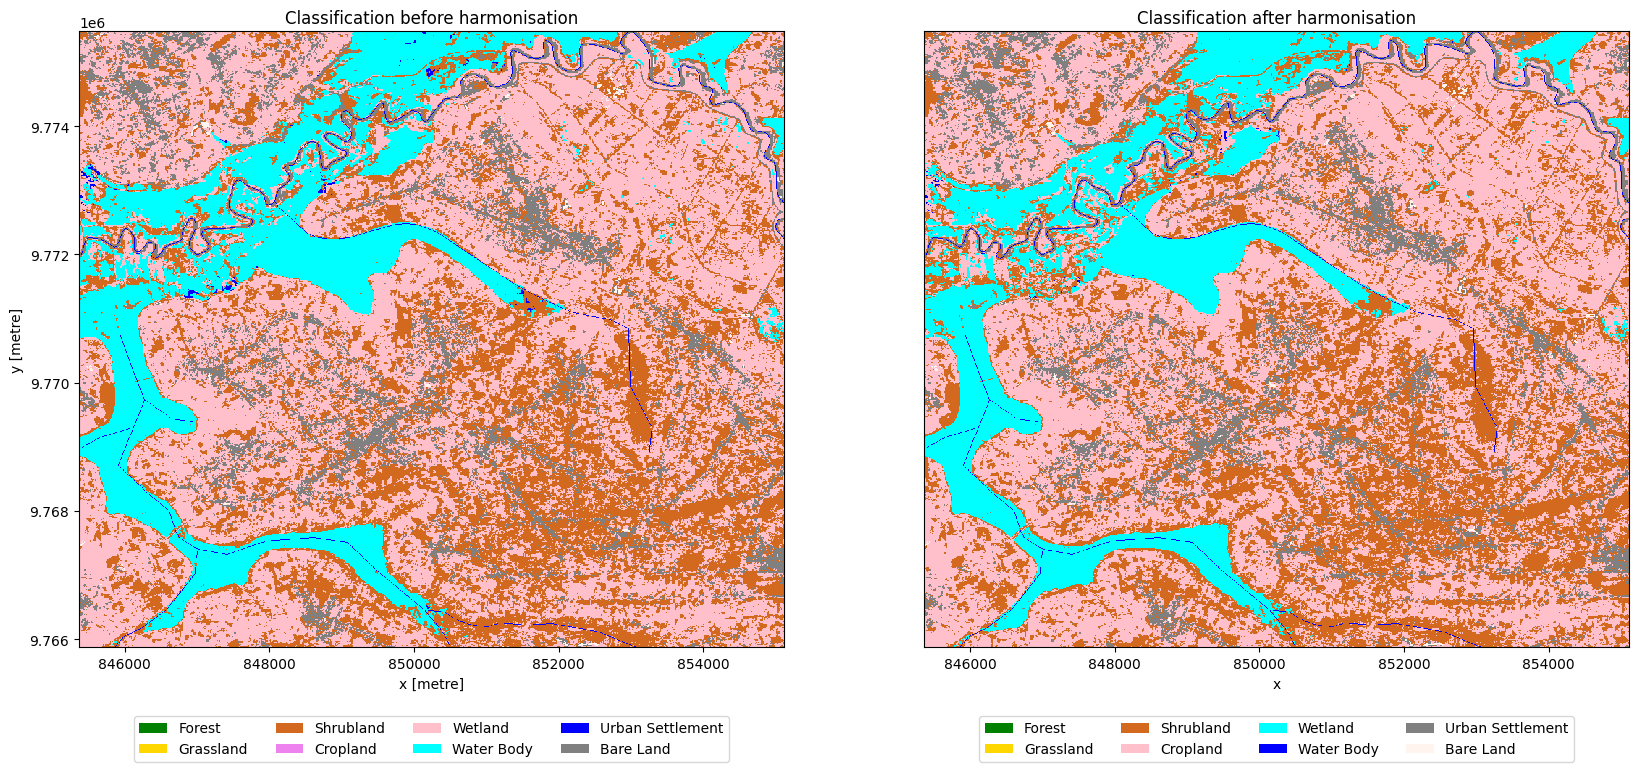

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colours = {1:'green', 5:'gold', 7:'chocolate',9:'violet',10:'pink',11:'cyan',12:'blue',13:'gray',14:'seashell'}
colours_merged={1:'green', 5:'gold', 7:'chocolate',10:'pink',11:'cyan',12:'blue',13:'gray',14:'seashell'}

patches_list=[Patch(facecolor=colour) for colour in colours.values()]
patches_list_merged=[Patch(facecolor=colour) for colour in colours_merged.values()]

# set color legends and color maps parameters
prediction_values=np.unique(xr_unharmonised)
cmap=ListedColormap([colours[k] for k in prediction_values])
norm = BoundaryNorm(list(prediction_values)+[np.max(prediction_values)+1], cmap.N)

prediction_values_merged=np.unique(xr_harmonised)
cmap_merged=ListedColormap([colours_merged[k] for k in prediction_values_merged])
norm_merged = BoundaryNorm(list(prediction_values_merged)+[np.max(prediction_values_merged)+1], cmap_merged.N)

xr_unharmonised.plot.imshow(ax=axes[0], 
               cmap=cmap,
               norm=norm,
               add_labels=True, 
               add_colorbar=False,
               interpolation='none')

xr_harmonised.plot.imshow(ax=axes[1], 
               cmap=cmap_merged,
               norm=norm_merged,
               add_labels=True, 
               add_colorbar=False,
               interpolation='none')

# Remove axis on middle and right plot
axes[1].get_yaxis().set_visible(False)
# add colour legends
axes[0].legend(patches_list, list(dict_map.keys()),
    loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))
axes[1].legend(patches_list_merged, list(dict_map.keys()),
    loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))
# Add plot titles
axes[0].set_title('Classification before harmonisation')
axes[1].set_title('Classification after harmonisation')

## Export results

In [52]:
write_cog(xr_harmonised, 'Results/Land_cover_prediction_postprocessed_harmonised.tif', overwrite=True)

PosixPath('Results/Land_cover_prediction_postprocessed_harmonised.tif')